# n78


In [1]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

from exputils.dot.get_topK_botK_Amat import get_topK_botK_Amat
from exputils.RoM.custom import calculate_RoM_custom
from exputils.RoM.fwht import calculate_RoM_FWHT
from exputils.stabilizer_group import total_stabilizer_group_size
from exputils.state.random import make_random_quantum_state

In [2]:
def calculate_RoM_n7_n8(
    n_qubit: int,
    rho_vec: np.ndarray,
    method: str = "gurobi",
    verbose: bool = False,
    iter_max: int = 10,
    eps: float = 1e-5,
    discard_current_threshold: float = 0.9,
):
    K = [1, 1, 1, 1, 0.1, 0.01, 0.001, 0.00001][n_qubit]

    current_Amat = get_topK_botK_Amat(n_qubit, rho_vec, K, verbose=False)

    RoM_hist = []
    violations_hist = []

    for it in range(iter_max):
        print(
            f"iteration: {it + 1} / {iter_max}, # of columns = {current_Amat.shape[1]}"
        )
        RoM, coeff, dual = calculate_RoM_custom(
            current_Amat,
            rho_vec,
            method=method,
            return_dual=True,
            crossover=False,
            presolve=False,
            verbose=verbose,
        )
        print(f"{RoM = }")
        RoM_hist.append(RoM)

        dual_Amat = get_topK_botK_Amat(n_qubit, dual, K, verbose=False)
        dual_dots = np.abs(dual.T @ dual_Amat)
        dual_violated_indices = dual_dots > 1 + eps
        violated_count = np.sum(dual_violated_indices)
        violations_hist.append(violated_count)
        print(
            "# of violations:",
            f"{violated_count}"
            if violated_count < dual_Amat.shape[1]
            else f"more than {violated_count}",
        )

        nonbasic_indices = np.abs(coeff) > eps
        critical_indices = np.abs(dual @ current_Amat) >= (
            discard_current_threshold - eps
        )
        remain_indices = np.logical_or(nonbasic_indices, critical_indices)
        current_Amat = current_Amat[:, remain_indices]

        if violated_count == 0:
            print("exact RoM found!")
            break
        else:
            indices = np.where(dual_violated_indices)[0]
            extra_Amat = dual_Amat[:, indices]

        current_Amat = scipy.sparse.hstack((current_Amat, extra_Amat))

    assert len(RoM_hist) == len(violations_hist)
    it = list(range(1, len(RoM_hist) + 1))
    fig = plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(it, RoM_hist, "o-")
    ax1.set_xlabel("iteration")
    ax1.set_ylabel("RoM")
    ax1.set_title("RoM vs. Iteration")

    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(it, violations_hist, "o-")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Violated Counts")
    ax2.set_yscale("log")
    ax2.set_title("Violated Counts vs. Iteration")

    fig.suptitle(
        f"{n_qubit=},{RoM=},FWHT RoM={calculate_RoM_FWHT(n_qubit, rho_vec)[0]}"
    )
    plt.tight_layout()
    plt.show()

    return RoM

start to calculate with C++
start: restore_Amat...
done
time: 4049[ms]
finish to calculate with C++
iteration: 1 / 10, # of columns = 315058
Set parameter Method to value 2
Set parameter Crossover to value 0
Set parameter Presolve to value 0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4096 rows, 630116 columns and 40327424 nonzeros
Model fingerprint: 0x624a5a5d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-06, 1e+00]
Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 4.193e+06
 Factor NZ  : 8.391e+06 (roughly 300 MB of memory)
 Factor Ops : 2.291e+10 (roughly 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal     

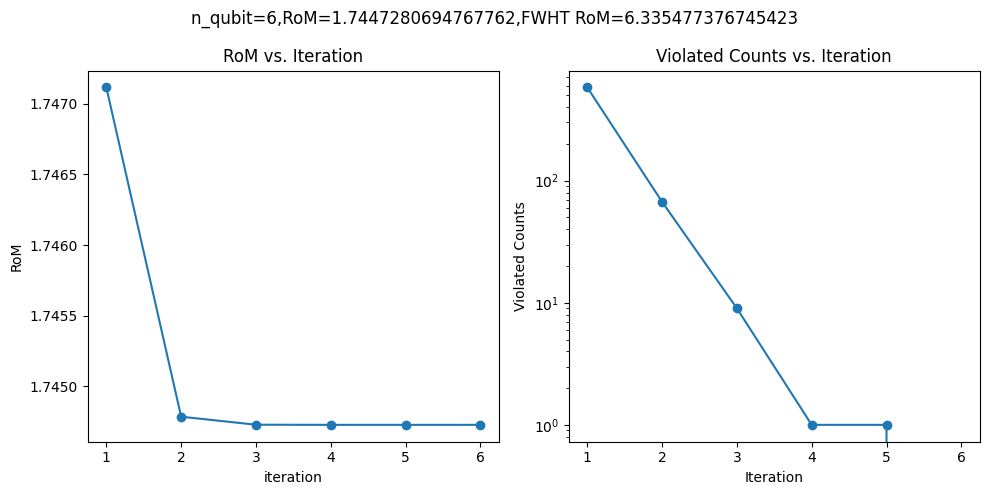

In [7]:
n_qubit = 6
rho_vec = make_random_quantum_state("mixed", n_qubit, 0)
RoM = calculate_RoM_n7_n8(n_qubit, rho_vec, method="gurobi", verbose=True)

iteration: 1 / 100, # of columns = 812848
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-08
Set parameter Method to value 2
Set parameter Crossover to value 0
Set parameter Presolve to value 0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 16384 rows, 1625696 columns and 208089088 nonzeros
Model fingerprint: 0x43c351ef
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-07, 1e+00]
Ordering time: 2.19s

Barrier statistics:
 AA' NZ     : 6.710e+07
 Factor NZ  : 1.342e+08 (roughly 1.7 GB of memory)
 Factor Ops : 1.466e+12 (roughly 16 seconds per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal        

make_cover_info:   0%|          | 0/129 [00:00<?, ?it/s]

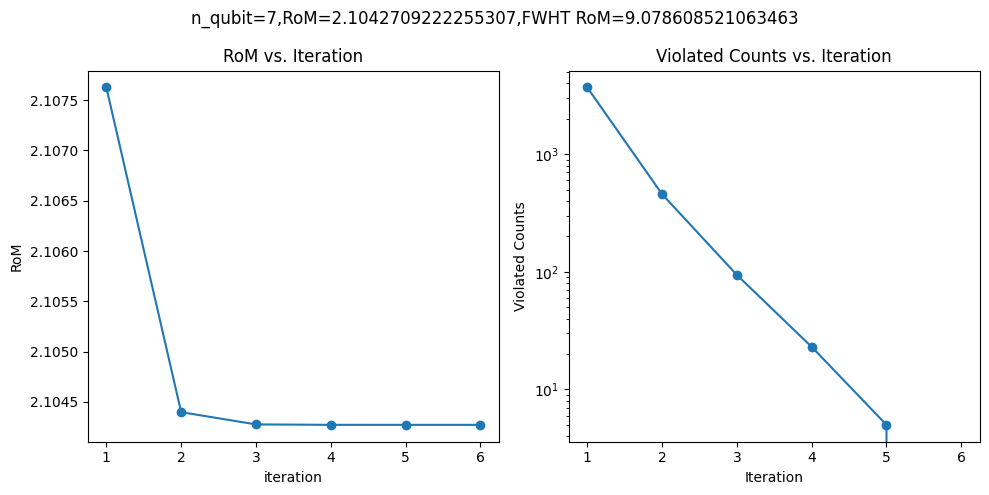

In [3]:
n_qubit = 7
rho_vec = make_random_quantum_state("mixed", n_qubit, 0)
RoM = calculate_RoM_n7_n8(n_qubit, rho_vec, method="gurobi", verbose=True, iter_max=100)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

n_qubit = 7
RoMs = [
    2.1076267488349822,
    2.104397199245355,
    2.104275445444534,
    2.1042710562355067,
    2.1042709211724557,
    2.1042709222255307,
]
violations = [
    3686,
    457,
    94,
    23,
    5,
    0,
]

sns.set_theme("paper")
sns.set(font_scale=1.5)


def visualize_multiple_Amat():
    fig = plt.figure(figsize=(8, 5))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    # plot RoMs to ax1 with seaborn
    sns.lineplot(x=list(range(1, len(RoMs) + 1)), y=RoMs, ax=ax1)
    ax1.set_xlabel("Iteration", fontsize=20)
    ax1.set_ylabel("RoM", fontsize=20)
    ax1.set_xticks(list(range(1, len(RoMs) + 1)))
    # plot violated counts to ax2 with seaborn
    sns.lineplot(x=list(range(1, len(violations) + 1)), y=violations, ax=ax2)
    ax2.set_xlabel("Iteration", fontsize=20)
    ax2.set_ylabel("Violated Counts", fontsize=20)
    ax2.set_xticks(list(range(1, len(violations) + 1)))
    fig.suptitle(f"n = {n_qubit}", fontsize=20)
    plt.tight_layout()
    plt.savefig(f"CG_{n_qubit}.pdf", bbox_inches="tight")
    plt.close()


if __name__ == "__main__":
    visualize_multiple_Amat()

K = 0.00001

FWHT = 9.078608521
